# Trousers and jeans model - Female classifier

# Import relevant libraries

In [1]:
import io
import itertools
import numpy as np
import sklearn.metrics
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

# Load the data

Data train files: ['images', 'labels']
Size of the images: (2002, 120, 90, 3)
Size of the labels: (2002,)
Unique values of the labels: [0 1]
The label of 586'th image is 0
The label of 585'th image is 0


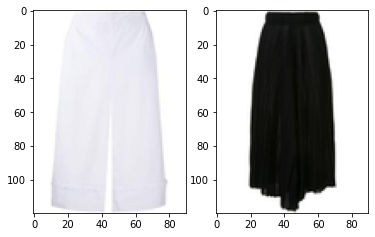

In [2]:
data_train = np.load(r"data/Trousers & Jeans - Female - Train.npz")
data_validation = np.load(r"data/Trousers & Jeans - Female - Validation.npz")
data_test = np.load(r"data/Trousers & Jeans - Female - Test.npz")

print("Data train files: {}".format(data_train.files))
print("Size of the images: {}".format(data_train['images'].shape))
print("Size of the labels: {}".format(data_train['labels'].shape))
print("Unique values of the labels: {}".format(np.unique(data_train['labels'])))
n = np.random.randint(0, 2002)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

n = np.random.randint(0, 2002)
ax2.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

In [3]:
images_train = data_train['images']
labels_train = data_train['labels']

images_val = data_validation['images']
labels_val = data_validation['labels']

images_test = data_test['images']
labels_test = data_test['labels']

In [4]:
images_train = images_train/255.0
images_val = images_val/255.0
images_test = images_test/255.0 

# Training the models

In [5]:
EPOCHS = 15
BATCH_SIZE = 64 #power of 2

HP_FILTER_SIZE_1 = hp.HParam('filter_size_1', hp.Discrete([3,5,7]))
HP_FILTER_NUM = hp.HParam('filters_number', hp.Discrete([32,64]))
HP_FILTER_SIZE_2 = hp.HParam('filter_size_2', hp.Discrete([3,5]))
HP_DENSE_SIZE = hp.HParam('dense_size', hp.Discrete([256,512]))

METRIC_ACCURACY = "accuracy"

with tf.summary.create_file_writer(r'Logs/Model 4_3/hparam_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE_1, HP_FILTER_NUM, HP_FILTER_SIZE_2, HP_DENSE_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [6]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [7]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [8]:
def train_test_model(hparams, session_num):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            hparams[HP_FILTER_NUM], 
            hparams[HP_FILTER_SIZE_1], 
            activation='relu',
            input_shape=(120,90,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(
            hparams[HP_FILTER_NUM], 
            hparams[HP_FILTER_SIZE_2], 
            activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_DENSE_SIZE], activation='relu'),
        tf.keras.layers.Dense(2)
    ])
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_fn, metrics=['accuracy'])
    

    log_dir = "Logs\\Model 4_3\\fit\\" + "run {}".format(session_num)
    
  
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
    
    def log_confusion_matrix(epoch, logs):
        
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
       
        figure = plot_confusion_matrix(cm, class_names=['Trousers', 'Jeans'])
        cm_image = plot_to_image(figure)

        
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    

    
 
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    

    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val,labels_val),
        verbose = 2
    )
    
    

    _, accuracy = model.evaluate(images_val,labels_val)
    

    model.save(r"saved_models\Model 4_3\Run-{}".format(session_num))
    
    return accuracy

In [9]:
def run(log_dir, hparams, session_num):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams, session_num)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step = 1)

In [10]:
session_num = 1

for filter_size_1 in HP_FILTER_SIZE_1.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:
        for filter_size_2 in HP_FILTER_SIZE_2.domain.values:
            for dense_size in HP_DENSE_SIZE.domain.values:

                    hparams = {
                        HP_FILTER_SIZE_1: filter_size_1,
                        HP_FILTER_NUM: filter_num,
                        HP_FILTER_SIZE_2: filter_size_2,
                        HP_DENSE_SIZE: dense_size
                    }

                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('Logs/Model 4_3/hparam_tuning/' + run_name, hparams, session_num)

                    session_num += 1

--- Starting trial: run-1
{'filter_size_1': 3, 'filters_number': 32, 'filter_size_2': 3, 'dense_size': 256}
Epoch 1/15
32/32 - 10s - loss: 0.8056 - accuracy: 0.6304 - val_loss: 0.6070 - val_accuracy: 0.6760
Epoch 2/15
32/32 - 6s - loss: 0.5119 - accuracy: 0.7393 - val_loss: 0.5285 - val_accuracy: 0.7360
Epoch 3/15
32/32 - 7s - loss: 0.4454 - accuracy: 0.7857 - val_loss: 0.4493 - val_accuracy: 0.7720
Epoch 4/15
32/32 - 8s - loss: 0.3952 - accuracy: 0.8157 - val_loss: 0.4159 - val_accuracy: 0.7800
Epoch 5/15
32/32 - 8s - loss: 0.3587 - accuracy: 0.8282 - val_loss: 0.4348 - val_accuracy: 0.7840
Epoch 6/15
32/32 - 9s - loss: 0.3389 - accuracy: 0.8357 - val_loss: 0.5148 - val_accuracy: 0.7640
8/8 [==============================] - 0s 19ms/step - loss: 0.4159 - accuracy: 0.7800
INFO:tensorflow:Assets written to: saved_models\Model 4_3\Run-1\assets
--- Starting trial: run-2
{'filter_size_1': 3, 'filters_number': 32, 'filter_size_2': 3, 'dense_size': 512}
Epoch 1/15
32/32 - 9s - loss: 1.0248 -

Epoch 4/15
32/32 - 33s - loss: 0.4426 - accuracy: 0.7877 - val_loss: 0.5019 - val_accuracy: 0.7400
Epoch 5/15
32/32 - 32s - loss: 0.4357 - accuracy: 0.7822 - val_loss: 0.4513 - val_accuracy: 0.7720
Epoch 6/15
32/32 - 32s - loss: 0.3848 - accuracy: 0.8282 - val_loss: 0.4558 - val_accuracy: 0.7720
Epoch 7/15
32/32 - 32s - loss: 0.3460 - accuracy: 0.8347 - val_loss: 0.4440 - val_accuracy: 0.7680
Epoch 8/15
32/32 - 30s - loss: 0.3352 - accuracy: 0.8482 - val_loss: 0.5129 - val_accuracy: 0.7480
Epoch 9/15
32/32 - 30s - loss: 0.3027 - accuracy: 0.8726 - val_loss: 0.4085 - val_accuracy: 0.8160
Epoch 10/15
32/32 - 28s - loss: 0.2780 - accuracy: 0.8781 - val_loss: 0.4189 - val_accuracy: 0.8440
Epoch 11/15
32/32 - 30s - loss: 0.2566 - accuracy: 0.8876 - val_loss: 0.4314 - val_accuracy: 0.8120
8/8 [==============================] - 1s 93ms/step - loss: 0.4085 - accuracy: 0.8160
INFO:tensorflow:Assets written to: saved_models\Model 4_3\Run-8\assets
--- Starting trial: run-9
{'filter_size_1': 5, 'f

Epoch 10/15
32/32 - 22s - loss: 0.3541 - accuracy: 0.8197 - val_loss: 0.4265 - val_accuracy: 0.7640
8/8 [==============================] - 1s 64ms/step - loss: 0.4125 - accuracy: 0.7920
INFO:tensorflow:Assets written to: saved_models\Model 4_3\Run-14\assets
--- Starting trial: run-15
{'filter_size_1': 5, 'filters_number': 64, 'filter_size_2': 5, 'dense_size': 256}
Epoch 1/15
32/32 - 30s - loss: 0.9983 - accuracy: 0.6319 - val_loss: 0.6225 - val_accuracy: 0.6600
Epoch 2/15
32/32 - 29s - loss: 0.5440 - accuracy: 0.7353 - val_loss: 0.5772 - val_accuracy: 0.7080
Epoch 3/15
32/32 - 29s - loss: 0.5140 - accuracy: 0.7498 - val_loss: 0.4947 - val_accuracy: 0.7600
Epoch 4/15
32/32 - 29s - loss: 0.4669 - accuracy: 0.7627 - val_loss: 0.4767 - val_accuracy: 0.7800
Epoch 5/15
32/32 - 30s - loss: 0.4402 - accuracy: 0.7692 - val_loss: 0.4494 - val_accuracy: 0.7640
Epoch 6/15
32/32 - 30s - loss: 0.4176 - accuracy: 0.7767 - val_loss: 0.4595 - val_accuracy: 0.7720
Epoch 7/15
32/32 - 31s - loss: 0.4057 -

Epoch 6/15
32/32 - 41s - loss: 0.4305 - accuracy: 0.7852 - val_loss: 0.4643 - val_accuracy: 0.7640
Epoch 7/15
32/32 - 42s - loss: 0.4177 - accuracy: 0.7922 - val_loss: 0.4822 - val_accuracy: 0.8000
Epoch 8/15
32/32 - 41s - loss: 0.4246 - accuracy: 0.7792 - val_loss: 0.5159 - val_accuracy: 0.7720
8/8 [==============================] - 1s 121ms/step - loss: 0.4643 - accuracy: 0.7640
INFO:tensorflow:Assets written to: saved_models\Model 4_3\Run-23\assets
--- Starting trial: run-24
{'filter_size_1': 7, 'filters_number': 64, 'filter_size_2': 5, 'dense_size': 512}
Epoch 1/15
32/32 - 42s - loss: 0.9322 - accuracy: 0.6114 - val_loss: 0.7056 - val_accuracy: 0.6520
Epoch 2/15
32/32 - 25s - loss: 0.5832 - accuracy: 0.7038 - val_loss: 0.5279 - val_accuracy: 0.7480
Epoch 3/15
32/32 - 23s - loss: 0.5111 - accuracy: 0.7498 - val_loss: 0.5136 - val_accuracy: 0.7280
Epoch 4/15
32/32 - 23s - loss: 0.4787 - accuracy: 0.7607 - val_loss: 0.4722 - val_accuracy: 0.7960
Epoch 5/15
32/32 - 23s - loss: 0.4629 -

In [11]:
%load_ext tensorboard
%tensorboard --logdir "Logs/Model 4_3/hparam_tuning"